In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import savez_compressed

import os
# from drive.MyDrive.AIHealthcare.happybot_master.nn.facs_helper import *
from drive.MyDrive.AIHealthcare.happybot_master.nn import facs_helper
from drive.MyDrive.AIHealthcare.happybot_master.nn import facs_preparation
from drive.MyDrive.AIHealthcare.happybot_master.happybot import tf_helper
# import drive.MyDrive.AIHealthcare.happybot_master.nn.facs_preparation

import time
import cv2
from drive.MyDrive.AIHealthcare.happybot_master.happybot import tf_helper
from drive.MyDrive.AIHealthcare.happybot_master.happybot import facs_helper
from drive.MyDrive.AIHealthcare.happybot_master.happybot import blob_detector
from drive.MyDrive.AIHealthcare.happybot_master.happybot import face_helper
from google.colab.patches import cv2_imshow

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
facsList = [  1.,   2.,   4.,   5.,   6.,   7.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  20.,  21.,  22.,  23.,  24.,  25.,
        26.,  27.,  28.,  29.,  30.,  31.,  34.,  38.,  39.,  43.,  44.,
        45.,  54.,  61.,  62.,  63.,  64.]
facsPaper = [5., 9., 12., 15., 16.,20.,23., 24.] # Kotsia FAU
# 6
facsTop = [1.,2.,4.,5.,6.,7.]

# 11
facsBtm = np.array([9., 10., 12., 15., 17., 20., 23.,24., 25., 26., 27.])

facsBtm = [9., 10., 12., 15., 17., 20., 23.,24., 25., 26., 27.]
# useBotIdx = np.array([0,2,3,4,5,8,10], dtype = np.int32) # You can select which AUs you train for with this array. 

In [4]:
# upper len = 6
dict_upper = ['AU1: Inner Brow Raiser','AU2: Outer Brow Raiser','AU4: Brow Lowerer','AU5: Upper Lid Raiser','AU6: Cheek Raiser','AU7: Lid Tightener']
print('dict_upper', len(dict_upper))

# lower len = 11
dict_lower = ['AU9: Nose Wrinkler', 'AU10: Upper Lip Raiser', 'AU12: Lip Corner Puller',
              'AU15: Lip Corner Depressor',  'AU17: Chin Raiser',  'AU20: Lip Stretcher',
              'AU23: Lip Tightener','AU24: Lip Pressor', 'AU25: Lips Part',  'AU26: Jaw Drop',
              'AU27: Mouth Stretch']

# emotion = 7
print('dict_lower',len(dict_lower))
dict_emotion = ['Thinking...', 'Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']

font_size = .6
font = cv2.FONT_HERSHEY_SIMPLEX
face_op = face_helper.faceUtil()
vec = np.empty([68, 2], dtype = int)

# tol = 5 
tol = 10 
width = 640
height = 480

scaleFactor = 0.4
scaleUp = 3/4
centerFixed = np.array((int(width*scaleFactor / 2), int(height*scaleFactor /2) ))

oriented_bool = False
face_bool = False
second_seek_bool = False

not_face_count = 0
not_face_count_thresh = 30

thresh = 15

# Set x and y center of frame.
yCenter = centerFixed[1]
xCenter = centerFixed[0]
motor_thresh = int(50 * scaleFactor)

# Position of text on video when face is detected. 
pos_lower = (np.arange(175, 450, 25)*scaleUp).astype(int)
pos_upper = (np.arange(25,175,25)*scaleUp).astype(int)
pos_emotion = (np.arange(25,225,25)*scaleUp).astype(int)

# Counts iterations when face is not found. 
iter_count = 0
groundFeatUpper = []
groundFeatLower = []
facialMotionUpper = []
facialMotionLower = []
neutralBool = False

# load_file_low = 'drive/MyDrive/AIHealthcare/happybot_master/bot/model-3000'
# load_file_up = 'drive/MyDrive/AIHealthcare/happybot_master/top/model-3000/model-3000'

load_file_low = 'drive/MyDrive/AIHealthcare/happybot_master/nn/bottom/model-3000'
load_file_up = 'drive/MyDrive/AIHealthcare/happybot_master/nn/top/model-3000'

# Tensorflow model for lower and upper face. 
modelLow = tf_helper.ImportGraph(load_file_low)
modelUp = tf_helper.ImportGraph(load_file_up)

dict_upper 6
dict_lower 11
INFO:tensorflow:Restoring parameters from drive/MyDrive/AIHealthcare/happybot_master/nn/bottom/model-3000
INFO:tensorflow:Restoring parameters from drive/MyDrive/AIHealthcare/happybot_master/nn/top/model-3000


In [5]:
ls 'drive/MyDrive/AIHealthcare/Desktop/ran_replicate/datasets/CKPlus/cohn-kanade-images/S010/001/S010_001_00000014.png'

drive/MyDrive/AIHealthcare/Desktop/ran_replicate/datasets/CKPlus/cohn-kanade-images/S010/001/S010_001_00000014.png


In [6]:
ls 'drive/MyDrive/AIHealthcare/Desktop/ran_replicate/datasets/CKPlus/FACS/S005/001/S005_001_00000011_facs.txt'

drive/MyDrive/AIHealthcare/Desktop/ran_replicate/datasets/CKPlus/FACS/S005/001/S005_001_00000011_facs.txt


facsLow = [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
facsUp = [[0. 0. 0. 0.]]
emotion 0


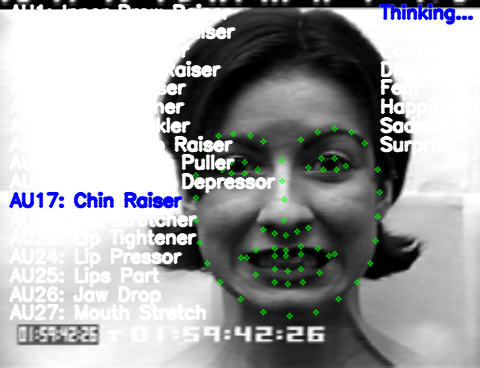

In [9]:
blob = blob_detector.blobFinder(xCenter, yCenter, thresh, motor_thresh)
image = cv2.imread('drive/MyDrive/AIHealthcare/Desktop/ran_replicate/datasets/CKPlus/cohn-kanade-images/S010/001/S010_001_00000014.png')
# image = cv2.imread('/content/1.jpg')

small_frame = cv2.resize(image, (0, 0), fx=scaleFactor, fy=scaleFactor)
# cv2_imshow(small_frame)
# print('small_frame',small_frame.shape)

mean_max, max_area, blob_bool = blob.find_blob(small_frame)
# print('blob_bool',blob_bool)

centered_bool, xShift, yShift = blob.check_centered(mean_max)
# print('centered_bool',centered_bool)

# cv2_imshow(small_frame)
face_bool = face_op.face_detect(small_frame, face_bool)
# print('face detected')

vec, point, face_bool = face_op.get_vec(small_frame, centerFixed, face_bool)
# cv2.circle(small_frame, (point[0], point[1]),5,(0,255,0),-1)
# print('vec ==', vec.shape)
# print('point ==', point)
# print('face_bool ==', face_bool)

feat = facs_helper.facialActions(vec,small_frame)
# print('feat =',feat)

newFeaturesUpper = feat.detectFeatures()
newFeaturesLower = feat.detectLowerFeatures()
# print('newFeaturesUpper =', len(newFeaturesUpper))
# print('newFeaturesLower =', len(newFeaturesLower))
    
if np.any(point) > 0: # Facial location is detected and the face has been detected
    centered_face_bool, xShift_face, yShift_face = blob.check_centered(point)
    neutralBool, neutralFeaturesUpper, neutralFeaturesLower = face_op.set_neutral(feat, newFeaturesUpper, newFeaturesLower, neutralBool,tol)
    # print('neutralFeaturesUpper =', len(neutralFeaturesUpper))
    # print('neutralFeaturesLower =', len(neutralFeaturesLower))

# Increase size of frame for viewing. 
big_frame = cv2.resize(small_frame, (0, 0), fx=scaleUp * 1/scaleFactor, fy=scaleUp *1/scaleFactor)

# Show text on video. 
for idxJ, dd in enumerate(dict_upper):
  cv2.putText(big_frame, dd,(10,pos_upper[idxJ]), font, font_size,(255,255,255),2,cv2.LINE_AA)
for idxJ, dd in enumerate(dict_lower):
  cv2.putText(big_frame, dd,(10,pos_lower[idxJ]), font, font_size,(255,255,255),2,cv2.LINE_AA)
for idxJ, dd in enumerate(dict_emotion):
  cv2.putText(big_frame, dd,(380,pos_emotion[idxJ]), font, font_size,(255,255,255),2,cv2.LINE_AA)

# Neutral expression is set. 
if neutralBool:
    # Just reshape variables. 11, 25, 19
    facialMotionUp = np.reshape(feat.UpperFaceFeatures(neutralFeaturesUpper, newFeaturesUpper),(-1,19))
    # print('facialMotionUp', facialMotionUp.shape)
    facialMotionLow = np.reshape(feat.LowerFaceFeatures(neutralFeaturesLower, newFeaturesLower),(-1,6))
    # print('facialMotionLow', facialMotionLow.shape)
    
    # Predict AUs with TF model. 
    facsLow = modelLow.run(facialMotionLow)
    print('facsLow =', facsLow)
    facsUp = modelUp.run(facialMotionUp)
    print('facsUp =', facsUp)
    # Predict emotion based on AUs. |
    feel = tf_helper.facs2emotion(facsUp[0,:], facsLow[0,:])
    emotion = feel.declare()
    print('emotion', emotion)

    # Get index of AUs.
    idxFacsLow = np.where(facsLow[0,:]==1)
    idxFacsUp = np.where(facsUp[0,:]==1)

    if emotion == 5: # If emotion is happiness.
        face_bool = False
        not_face_count= not_face_count_thresh+1
        
    # Write text on frame. 
    if len(idxFacsLow) >0:
        for ii in idxFacsLow[0]:
            cv2.putText(big_frame, dict_lower[ii],(10,pos_lower[ii]), font, font_size,(255,0,0),2,cv2.LINE_AA)
    if len(idxFacsUp) >0:
        for jj in idxFacsUp[0]:
            cv2.putText(big_frame, dict_upper[jj],(10,pos_upper[jj]), font, font_size,(255,0,0),2,cv2.LINE_AA)  
    cv2.putText(big_frame, dict_emotion[emotion],(380,pos_emotion[emotion]), font, font_size,(255,0,0),2,cv2.LINE_AA)  

cv2_imshow(big_frame)